# Lid Driven Cavity Problem

By - Apoorv Bhardwaj - 23117026
     Atharv Priyadarshi - 23117034

### Cell 1: Import Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Imports NumPy for numerical computations and Matplotlib for plotting.

### Cell 2: Setup Domain

In [6]:
def setup_domain(n_x, l=1.0):
    n_y = n_x
    delta_x = l / (n_x - 1)
    x = np.linspace(0, l, n_x)
    y = np.linspace(0, l, n_y)
    return n_x, n_y, delta_x, x, y

Defines the computational grid.  `n_x` is the number of grid points in the x-direction, and `l` is the length of the square cavity (default is 1.0).  It returns the number of grid points in x and y, the grid spacing (`delta_x`), and the x and y coordinates of the grid.

### Cell 3: Initialize Fields

In [9]:
def initialize_fields(n_x, n_y):
    omega = np.zeros((n_x, n_y))  # Vorticity
    psi = np.zeros_like(omega)  # Streamfunction
    u = np.zeros_like(omega)  # x-velocity component
    v = np.zeros_like(omega)  # y-velocity component
    return omega, psi, u, v

Initializes the vorticity (`omega`), streamfunction (`psi`), and velocity components (`u`, `v`) to zero arrays.  `n_x` and `n_y` are the number of grid points in the respective directions.

### Cell 4: Boundary Conditions

In [12]:
def boundary_conditions(omega, psi, delta_x, u_lid):
    omega[:, -1] = -2 * psi[:, -2] / delta_x**2 - 2 * u_lid / delta_x  # Top wall (moving lid)
    omega[:, 0] = -2 * psi[:, 1] / delta_x**2  # Bottom wall
    omega[0, :] = -2 * psi[1, :] / delta_x**2  # Left wall
    omega[-1, :] = -2 * psi[-2, :] / delta_x**2  # Right wall
    return omega

Applies boundary conditions to the vorticity field (`omega`). The top boundary represents the moving lid with velocity `u_lid`.  The other walls have no-slip boundary conditions. This implementation uses a second-order accurate finite difference approximation to represent the boundary conditions.

### Cell 5: Solver Functions

In [15]:
def vorticity_solver(omega, psi, delta_x, nu, dt):
    omega_new = omega.copy()
    omega_new[1:-1, 1:-1] = omega[1:-1, 1:-1] + dt * (
        nu * (omega[2:, 1:-1] + omega[:-2, 1:-1] + omega[1:-1, 2:] + omega[1:-1, :-2] - 4 * omega[1:-1, 1:-1]) / delta_x**2 -
        ((psi[1:-1, 2:] - psi[1:-1, :-2]) / (2 * delta_x)) * (omega[2:, 1:-1] - omega[:-2, 1:-1]) / (2 * delta_x) +
        ((psi[2:, 1:-1] - psi[:-2, 1:-1]) / (2 * delta_x)) * (omega[1:-1, 2:] - omega[1:-1, :-2]) / (2 * delta_x)
    )
    return omega_new


def streamfunction_solver(omega, psi, delta_x):
    psi[1:-1, 1:-1] = 0.25 * (
        omega[1:-1, 1:-1] * delta_x**2 + psi[2:, 1:-1] + psi[:-2, 1:-1] + psi[1:-1, 2:] + psi[1:-1, :-2]
    )
    return psi

def velocity_solver(psi, u, v, delta_x, u_lid):
    u[1:-1, 1:-1] = (psi[1:-1, 2:] - psi[1:-1, :-2]) / (2 * delta_x)
    v[1:-1, 1:-1] = -(psi[2:, 1:-1] - psi[:-2, 1:-1]) / (2 * delta_x)
    u[:, -1] = u_lid
    return u, v

def calculate_divergence(u, v, delta_x):
    du_dx = (u[2:, 1:-1] - u[:-2, 1:-1]) / (2 * delta_x)
    dv_dy = (v[1:-1, 2:] - v[1:-1, :-2]) / (2 * delta_x)
    div = du_dx + dv_dy
    return div

def calculate_vorticity(u, v, delta_x):
    dv_dx = (v[1:-1, 2:] - v[1:-1, :-2]) / (2 * delta_x)
    du_dy = (u[2:, 1:-1] - u[:-2, 1:-1]) / (2 * delta_x)
    omega = dv_dx - du_dy
    return omega


def lid_driven_cavity(n_x, re, u_lid=1.0, l=1.0, dt=0.001, max_iter=10000, tolerance=1e-7):
    n_x, n_y, delta_x, x, y = setup_domain(n_x, l)
    omega, psi, u, v = initialize_fields(n_x, n_y)
    nu = u_lid * l / re  # kinematic viscosity

    for iteration in range(max_iter):
        omega_prev = omega.copy()
        omega = boundary_conditions(omega, psi, delta_x, u_lid)
        omega = vorticity_solver(omega, psi, delta_x, nu, dt)
        psi = streamfunction_solver(omega, psi, delta_x)
        u, v = velocity_solver(psi, u, v, delta_x, u_lid)

        residual = np.max(np.abs(omega - omega_prev))
        if residual < tolerance:
            break

    div = calculate_divergence(u, v, delta_x)
    return x, y, u, v, psi, div, iteration, nu


def interpolate_field(field, x, y, px, py):
    i = np.searchsorted(x, px) - 1
    j = np.searchsorted(y, py) - 1
    dx = x[i+1] - x[i]
    dy = y[j+1] - y[j]
    wx = (px - x[i]) / dx
    wy = (py - y[j]) / dy

    i = np.clip(i, 0, field.shape[0]-2)
    j = np.clip(j, 0, field.shape[1]-2)

    f_interp = (1 - wx) * (1 - wy) * field[i, j] + \
                wx * (1 - wy) * field[i+1, j] + \
                (1 - wx) * wy * field[i, j+1] + \
                wx * wy * field[i+1, j+1]
    return f_interp

This cell defines the core solver functions.
- **`vorticity_solver(omega, psi, delta_x, nu, dt)`:** Solves for the vorticity at the next time step using an explicit finite difference method.  It uses the current vorticity, streamfunction, grid spacing, kinematic viscosity, and time step to calculate the updated vorticity.
- **`streamfunction_solver(omega, psi, delta_x)`:**  Solves the Poisson equation for the streamfunction using the successive over-relaxation (SOR) method.  This equation relates the vorticity to the streamfunction.
- **`velocity_solver(psi, u, v, delta_x, u_lid)`:** Calculates the velocity components (`u`, `v`) from the streamfunction using central differences. It also applies the boundary condition for the moving lid.
- **`calculate_divergence(u, v, delta_x)`:** Computes the divergence of the velocity field, which should be close to zero for incompressible flow. This serves as a check on the numerical solution.
- **`calculate_vorticity(u, v, delta_x)`:** Calculates the vorticity from the velocity field using central difference approximations of the velocity derivatives.
- **`lid_driven_cavity(n_x, re, u_lid, l, dt, max_iter, tolerance)`:**  This is the main driver function for the simulation. It sets up the domain, initializes the fields, iteratively solves for vorticity and streamfunction until convergence or the maximum number of iterations is reached.  It returns the x and y coordinates, velocity components (`u`, `v`), streamfunction (`psi`), divergence (`div`), number of iterations, and kinematic viscosity (`nu`).
- **`interpolate_field(field, x, y, px, py)`:** This helper function performs bilinear interpolation to estimate the field value (like velocity) at arbitrary particle locations (`px`, `py`) within the grid.

### Cell 6: Plotting Function

In [18]:
def plot_results(x, y, u, v, omega, psi, div, re, iterations, nu, num_particles=100, l=1, mu=0.01):
    X, Y = np.meshgrid(x, y)
    X_omega, Y_omega = np.meshgrid(x[1:-1], y[1:-1])
    X_div, Y_div = np.meshgrid(x[1:-1], y[1:-1])

    plt.figure(figsize=(8, 6))
    plt.contourf(X_omega, Y_omega, omega.T, 20, cmap='RdBu_r')
    plt.colorbar(label='Vorticity')
    plt.title(f'Vorticity Contours (Re={re})')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('scaled')
    plt.show()
    

    plt.figure(figsize=(8, 6))
    plt.quiver(X[::2, ::2], Y[::2, ::2], u.T[::2, ::2], v.T[::2, ::2], color='k')
    plt.title(f'Velocity Vectors (Re={re})')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('scaled')
    plt.show()
    

    np.random.seed(42) 
    px = np.random.rand(num_particles) * l
    py = np.random.rand(num_particles) * l

    dt_particles = 0.001
    for _ in range(500):
        u_p = interpolate_field(u, x, y, px, py)
        v_p = interpolate_field(v, x, y, px, py)
        px += u_p * dt_particles
        py += v_p * dt_particles

        px[px < 0] = -px[px < 0]
        px[px > l] = 2 * l - px[px > l]
        py[py < 0] = -py[py < 0]
        py[py > l] = 2 * l - py[py > l]

    plt.figure(figsize=(8, 6))
    plt.plot(px, py, 'k.', markersize=2)
    plt.title(f'Particle Tracking (Re={re})')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('scaled')
    plt.show()


    tau_top = mu * (u[:, -2] - u[:, -1]) / delta_x
    plt.figure(figsize=(6, 4))
    plt.plot(x, tau_top)
    plt.title("Shear Stress on Top Lid")
    plt.xlabel("X")
    plt.ylabel("Shear Stress")
    plt.show()


    plt.figure(figsize=(8, 6))
    plt.contourf(x, y, u.T, 20, cmap='viridis')
    plt.colorbar(label='U-velocity')
    plt.title(f'Lid-Driven Cavity (Re={re})')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('scaled')
    plt.show()

    
    plt.figure(figsize=(6, 4))
    plt.plot(y, u[n_x // 2, :])
    plt.title('Centerline U-velocity')
    plt.xlabel('Y')
    plt.ylabel('U')
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(8, 6))
    plt.contourf(X_div, Y_div, div.T, 20, cmap='magma')  # Corrected grid
    plt.colorbar(label='Divergence')
    plt.title(f'Divergence of Velocity Field (Max: {np.max(np.abs(div)):.2e})')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('scaled')
    plt.show()

    
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, psi.T, 20, cmap='viridis')
    plt.colorbar(label='Streamfunction (psi)')
    plt.title(f'Streamfunction Contours (Re={re})')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('scaled')
    plt.show()

    print(f"Simulation completed in {iterations+1} iterations.  Kinematic Viscosity (nu): {nu}")

### Cell 7: Main Execution Block

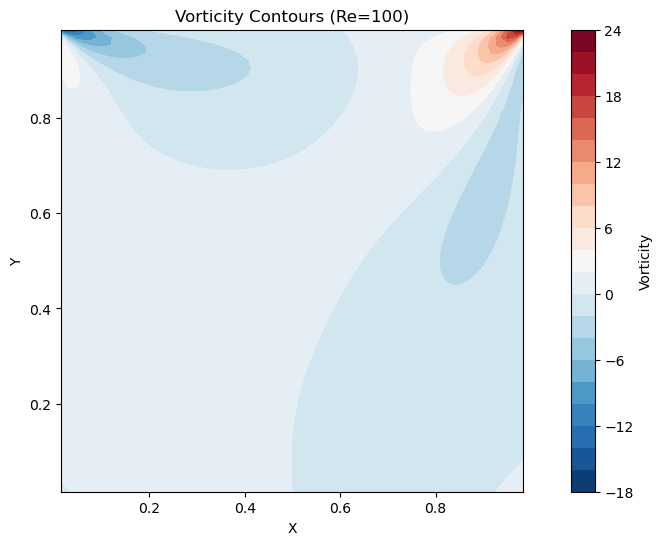

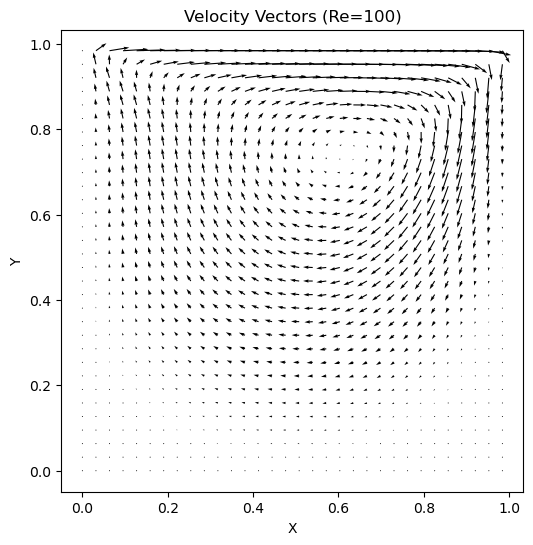

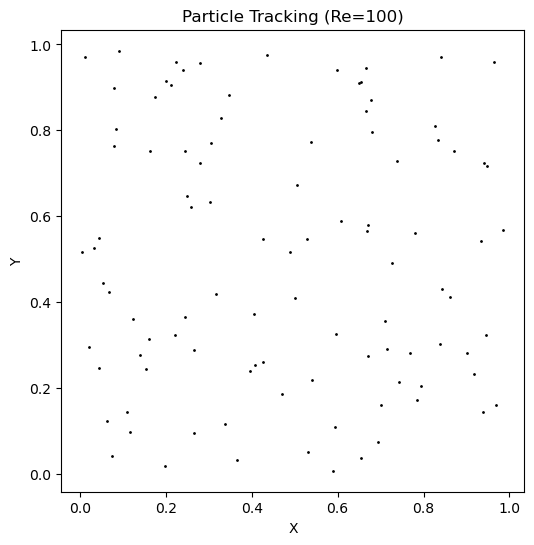

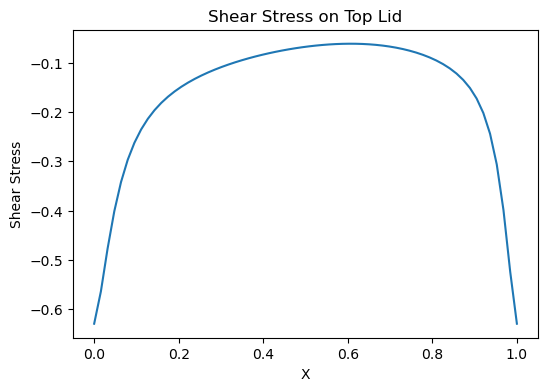

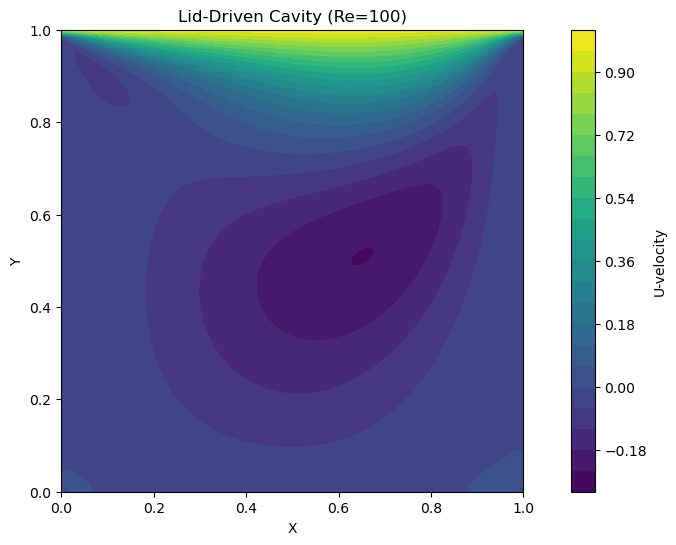

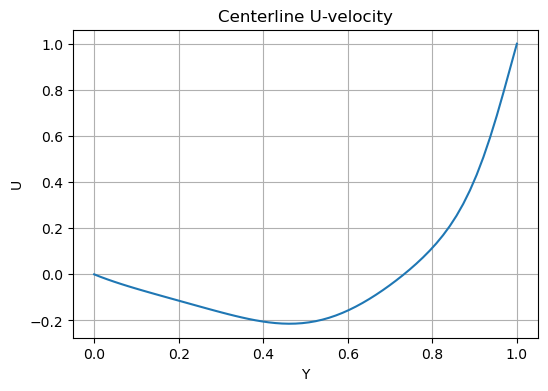

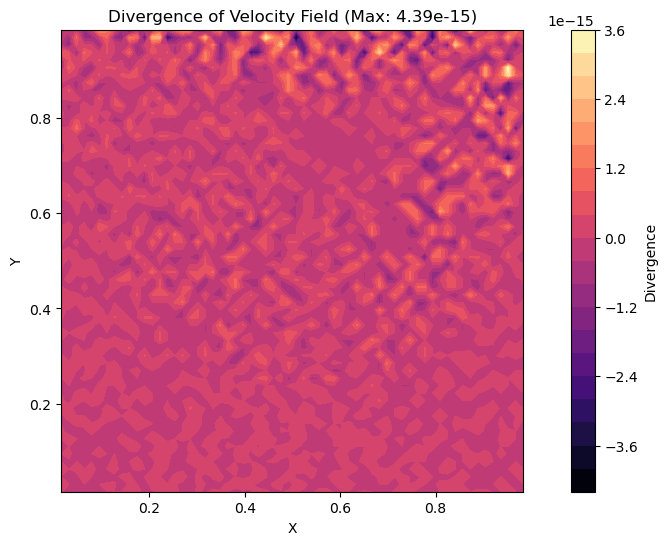

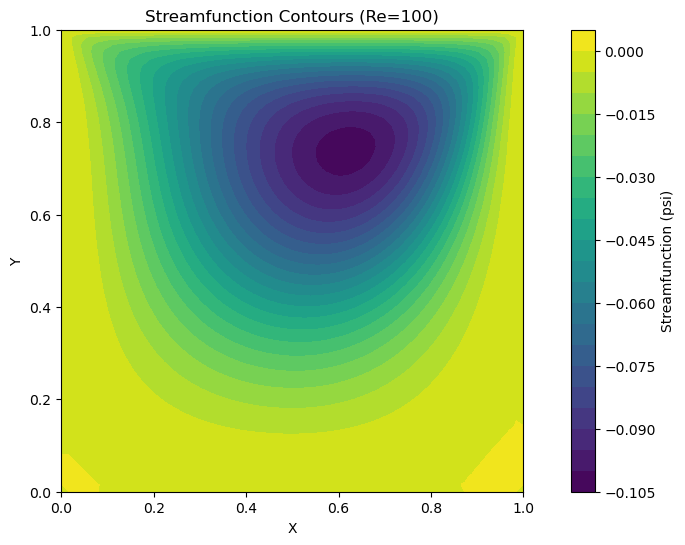

Simulation completed in 10000 iterations.  Kinematic Viscosity (nu): 0.01


In [20]:
n_x = 64
re = 100
l = 1.0  # Cavity dimension
x, y, u, v, psi, div, iterations, nu = lid_driven_cavity(n_x, re, l=l)
mu = nu * 1  # Assuming rho=1
delta_x = l / (n_x - 1)
omega = calculate_vorticity(u, v, delta_x)
plot_results(x, y, u, v, omega, psi, div, re, iterations, nu, l=l, mu=mu)

This cell is the main execution block of the code. It sets the parameters for the simulation, including grid size (`n_x`), Reynolds number (`re`), and domain length (`l`). It calls the `lid_driven_cavity` function to perform the simulation and then calls the `plot_results` function to visualize the results.  It is set up to run a simulation with a grid size of 64x64 and a Reynolds number of 100. You can modify these parameters to explore different flow regimes.  The parameter `l` sets the dimensions of the cavity.